In [1]:
from __future__ import annotations
import os
os.chdir('/home/elopez/RL-Project/DKONG')
import socket
HOSTNAME = socket.gethostname()

if HOSTNAME == "cudahpc16":
	# idk who set up this cluster but without this the gpu is not detected
	os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
	os.environ["CUDA_VISIBLE_DEVICES"] = "6"
	os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from pathlib import Path

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from _logging import load_config, load_pretrain_config
from models.base import CustomCNN
from pretrain_cnn import InverseDynamicsHead

In [ ]:
def build_models(device: torch.device) -> tuple[CustomCNN, InverseDynamicsHead, int]:
	main_config = load_config()
	pretrain_config = load_pretrain_config()
	frame_stack = int(main_config["env"]["frame_stack"])
	resize_h, resize_w = main_config["env"]["resize_observation"]
	c = 1  # after Grayscale + AddChannelDim
	obs_space = gym.spaces.Box(low=0, high=1, shape=(frame_stack * c, resize_h, resize_w), dtype=np.float32)

	features_dim = int(
		main_config["model"]["PPO"]["policy_kwargs"]["features_extractor_kwargs"].get("features_dim", 256)
	)
	extractor = CustomCNN(obs_space, features_dim=features_dim).to(device)

	n_actions = len(main_config["env"]["minimal_actions"])
	head_hidden_dim = int(pretrain_config["pretrain"].get("head_hidden_dim", 512))
	head = InverseDynamicsHead(features_dim * 2, head_hidden_dim, n_actions).to(device)
	return extractor, head, n_actions

main_config = load_config()
pretrain_config = load_pretrain_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
step = "0100000"
checkpoint_path = f"/data/users/elopez/checkpoints_dkong_pretrained/inverse_dynamics_v2_1/checkpoints/step_{step}.pt"
extractor, head, _ = build_models(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
extractor.load_state_dict(checkpoint["extractor_state_dict"])
head.load_state_dict(checkpoint["head_state_dict"])

<All keys matched successfully>

In [14]:
def compute_gradcam(
	extractor: CustomCNN,
	head: InverseDynamicsHead,
	s_t: torch.Tensor,
	s_tp1: torch.Tensor,
	action_idx: int,
	stack_choice: str,
	device: torch.device,
) -> tuple[np.ndarray, np.ndarray]:
	extractor.eval()
	head.eval()
	target_layer = extractor.cnn[6]  # last conv layer before relu/flatten

	past = s_t.unsqueeze(0).to(device)
	future = s_tp1.unsqueeze(0).to(device)

	def register_backward(layer, hook_fn):
		try:
			return layer.register_full_backward_hook(hook_fn)
		except AttributeError:
			return layer.register_backward_hook(lambda module, grad_input, grad_output: hook_fn(module, grad_input, grad_output))

	def run_gradcam(target_input: torch.Tensor, fixed_features: torch.Tensor, concat_order: str):
		activations: list[torch.Tensor] = []
		gradients: list[torch.Tensor] = []

		def fwd_hook(_, __, output):
			activations.clear()
			activations.append(output)

		def bwd_hook(_, __, grad_output):
			gradients.clear()
			gradients.append(grad_output[0])

		handle_f = target_layer.register_forward_hook(fwd_hook)
		handle_b = register_backward(target_layer, bwd_hook)

		z_target = extractor(target_input)
		if concat_order == "past_first":
			features = torch.cat([z_target, fixed_features], dim=1)
		else:
			features = torch.cat([fixed_features, z_target], dim=1)
		logits = head(features)
		score = logits[0, action_idx]
		extractor.zero_grad()
		head.zero_grad()
		score.backward()

		handle_f.remove()
		handle_b.remove()

		return activations[0], gradients[0]

	if stack_choice == "future":
		with torch.no_grad():
			z_past = extractor(past)
		target_input = future.detach().clone().requires_grad_(True)
		acts, grads = run_gradcam(target_input, z_past.detach(), concat_order="past_first")
	else:
		with torch.no_grad():
			z_future = extractor(future)
		target_input = past.detach().clone().requires_grad_(True)
		acts, grads = run_gradcam(target_input, z_future.detach(), concat_order="future_first")

	weights = grads.mean(dim=(2, 3), keepdim=True)
	cam = torch.relu((weights * acts).sum(dim=1, keepdim=True))
	cam = F.interpolate(cam, size=target_input.shape[-2:], mode="bilinear", align_corners=False)
	cam = cam.squeeze().detach().cpu().numpy()
	cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

	target_frame = target_input.detach().cpu().numpy()[0, -1, :, :]
	return cam, target_frame

In [38]:
def load_sample(dataset_path: Path, sample_idx: int) -> tuple[np.ndarray, np.ndarray, int]:
	data = np.load(dataset_path)
	s_t = data["s_t"][sample_idx]
	s_tp1 = data["s_tp1"][sample_idx]
	action = int(data["action"][sample_idx])
	return s_t, s_tp1, action

dataset_path = "/data/users/elopez/checkpoints_dkong_pretrained/inverse_dynamics_v2_1/dataset/chunk_00013.npz"
sample_idx = 50

s_t, s_tp1, action = load_sample(dataset_path, sample_idx)
s_t_tensor = torch.from_numpy(s_t).float()
s_tp1_tensor = torch.from_numpy(s_tp1).float()

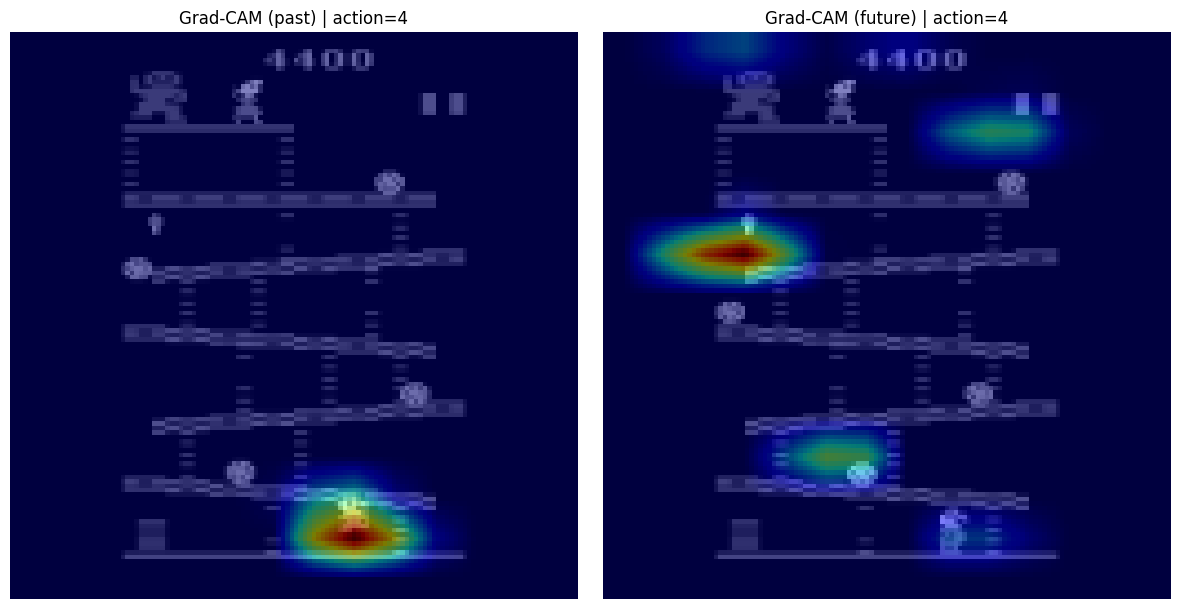

In [39]:
stack_choices = ["past", "future"]
results = []
for sc in stack_choices:
    cam, frame = compute_gradcam(
        extractor,
        head,
        s_t_tensor,
        s_tp1_tensor,
        action,
        stack_choice=sc,
        device=device,
    )
    results.append((cam, frame, sc))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, (cam, frame, sc) in enumerate(results):
    ax = axes[i]
    ax.imshow(frame, cmap="gray")
    ax.imshow(cam, cmap="jet", alpha=0.5)
    ax.axis("off")
    ax.set_title(f"Grad-CAM ({sc}) | action={action}")
plt.tight_layout()
plt.show()